<a href="https://colab.research.google.com/github/Signivis/SmartEmbed/blob/master/SpaceTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SpaceTime 🌌⏱️ Demo - S&P 500 Price Forecasting + Trading

A quick demo and walkthrough of SpaceTime, using S&P 500 index prices as a sample dataset.  
* In Part 1, we'll walkthrough how to train SpaceTime models for forecasting, aiming to predict future S&P 500 index prices.  
* In Part 2, we'll create a simple trading bot using these forecasts. 

None of this is financial advice!

### Setup

In [ ]:
# Install SpaceTime code
!git clone https://github.com/HazyResearch/spacetime.git

fatal: destination path 'spacetime' already exists and is not an empty directory.


In [ ]:
# General Setup
import os
import sys

from os.path import join

# Local imports from spacetime
project_dir = './spacetime'
sys.path.insert(0, os.path.abspath(project_dir)) 

In [ ]:
# The data science trinity, we might not use all of them
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Installing dependencies - as a quick hack for colab we'll just convert the 
# environment.yaml into a requirements.txt, and use pip to install everything.
# Code below from https://gist.github.com/pemagrg1/f959c19ec18fee3ce2ff9b3b86b67c16
import yaml

with open(join(project_dir, 'environment.yaml')) as file_handle:
    environment_data = yaml.safe_load(file_handle)

requirements = []
for dep in environment_data['dependencies']:
    if isinstance(dep, str):
        try:
            package, package_version = dep.split('=')
            package_version = f'=={package_version}'
        except:
            package = dep
            package_version = ''
        if package not in ['python', 'pip', 'jupyter', 'jupyterlab',
                           'pytorch', 'pandas', 'numpy', 'matplotlib']:
            requirements.append(f'{package}{package_version}')
    elif isinstance(dep, dict):
        for preq in dep.get('pip', []):
            requirements.append(preq)

with open('requirements.txt', 'w') as fp:
    for requirement in requirements:
       print(requirement, file=fp)


In [ ]:
# Install dependencies
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Part 1: Training to forecast with SpaceTime

We'll first download and setup some data via the Yahoo Finance API, showing how we can structure this data into a forecasting task and Pytorch dataloader for SpaceTime training. 

We'll then setup a SpaceTime model, walking through its configs and components. 

We'll finally train our SpaceTime model and visualize the results!

In [ ]:
from omegaconf import OmegaConf

In [ ]:
from utils.logging import print_config


In [ ]:
# Hacky args via an OmegaConf config
args = """
seed: 42
"""
args = OmegaConf.create(args)
print_config(args)

CONFIG
└── seed
    └── 42                                                                                                         

### Part 1.1 Data + Task

#### Load and setup data

We'll start out with predicting closing prices for the S&P 500.

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf

In [ ]:
yf_data = yf.Ticker('^GSPC')  # Ticker for S&P 500

In [ ]:
data = yf_data.history(period='max', start='1993-01-01',  # wow 30 years of data
                       auto_adjust=True)  

In [ ]:

df = pd.DataFrame(data).reset_index()

In [ ]:
# Visualize what we're dealing with
display(df.head(3))
display(df.tail(3))

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1993-01-04 00:00:00-05:00,435.700012,437.320007,434.480011,435.380005,201210000,0.0,0.0
1,1993-01-05 00:00:00-05:00,435.380005,435.399994,433.549988,434.339996,240350000,0.0,0.0
2,1993-01-06 00:00:00-05:00,434.339996,435.170013,432.519989,434.519989,295240000,0.0,0.0


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
7609,2023-03-22 00:00:00-04:00,4002.040039,4039.489990,3936.169922,3936.969971,4533010000,0.0,0.0
7610,2023-03-23 00:00:00-04:00,3959.209961,4007.659912,3919.050049,3948.719971,4991600000,0.0,0.0
7611,2023-03-24 00:00:00-04:00,3939.209961,3972.739990,3909.159912,3970.989990,4583970000,0.0,0.0


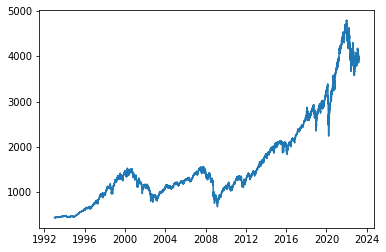

In [ ]:
# Visualize closing prices
plt.plot(df['Date'], df['Close'])
plt.show()

#### Structure data 

We want a model that can forecast out a horizon of future terms given some past historical lag terms. To do so, we'll structure the data into a "sliding window" of sample inputs and targets `x, y`, where input `x` is a sequence of neighboring lag terms and target `y` is a sequence of neighboring horizon terms.

#### Set lag and horizon prediction task

In [ ]:
args.lag = 84          # We'll use the prior 12 calendar weeks as inputs
args.horizon = 20      # We'll then try to predict out the next 20 available days (4ish working weeks)
args.target = 'Close'  # Pick one feature to forecast 

# Windows of samples
samples = [w.to_numpy() for w in df[args.target].rolling(window=args.lag + args.horizon)][args.lag + args.horizon - 1:]
# Dates for each sample
dates = [w for w in df['Date'].rolling(window=args.lag + args.horizon)][args.lag + args.horizon - 1:]

In [ ]:
len(samples)  # Total number of samples

7509

In [ ]:
dates[0]  # Double-check we're dealing with lag + horizon dates per sample

0     1993-01-04 00:00:00-05:00
1     1993-01-05 00:00:00-05:00
2     1993-01-06 00:00:00-05:00
3     1993-01-07 00:00:00-05:00
4     1993-01-08 00:00:00-05:00
                 ...           
99    1993-05-25 00:00:00-04:00
100   1993-05-26 00:00:00-04:00
101   1993-05-27 00:00:00-04:00
102   1993-05-28 00:00:00-04:00
103   1993-06-01 00:00:00-04:00
Name: Date, Length: 104, dtype: datetime64[ns, America/New_York]

#### Set evaluation timeframe
We'll see if we can predict market prices starting in 2022. To do so, we'll roughly construct a test set from the samples where the horizon terms start occurring in 2022 (note that for the first test samples, we'll then have some lag terms that occur in 2021).

We'll then create training and validation sets from the remaining data. 

In [ ]:
import datetime

test_year = 2022  
test_date = datetime.date(test_year, 1, min(args.horizon, 30)) 

## Convert 'Date' to datetime object
df['Date'] = pd.to_datetime(df['Date']).dt.date

## Find indices corresponding to test year dates
test_ix = len(dates) - df[df['Date'] >= test_date].shape[0]

In [ ]:
# Check that the horizon dates are roughly in 2022
dates[test_ix][args.lag:args.lag + args.horizon]

7297   2021-12-22 00:00:00-05:00
7298   2021-12-23 00:00:00-05:00
7299   2021-12-27 00:00:00-05:00
7300   2021-12-28 00:00:00-05:00
7301   2021-12-29 00:00:00-05:00
7302   2021-12-30 00:00:00-05:00
7303   2021-12-31 00:00:00-05:00
7304   2022-01-03 00:00:00-05:00
7305   2022-01-04 00:00:00-05:00
7306   2022-01-05 00:00:00-05:00
7307   2022-01-06 00:00:00-05:00
7308   2022-01-07 00:00:00-05:00
7309   2022-01-10 00:00:00-05:00
7310   2022-01-11 00:00:00-05:00
7311   2022-01-12 00:00:00-05:00
7312   2022-01-13 00:00:00-05:00
7313   2022-01-14 00:00:00-05:00
7314   2022-01-18 00:00:00-05:00
7315   2022-01-19 00:00:00-05:00
7316   2022-01-20 00:00:00-05:00
Name: Date, dtype: datetime64[ns, America/New_York]

#### Create training and validation splits

In [ ]:
def train_val_split(data_indices, val_ratio=0.1):
    train_ratio = 1 - val_ratio
    last_train_index = int(np.round(len(data_indices) * train_ratio))
    return data_indices[:last_train_index], data_indices[last_train_index:]

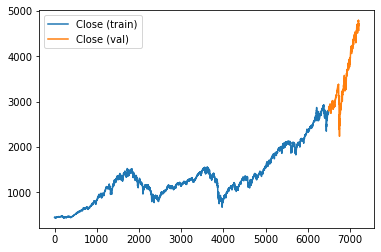

In [ ]:
# Split data indices for train and val sets
train_indices, val_indices = train_val_split(np.arange(test_ix))
train_samples = np.array(samples[:val_indices[0]])
val_samples = np.array(samples[val_indices[0]:val_indices[-1]])

# Sanity check the splits by plotting the last horizon term in each sample
ix = -1
plt.plot(train_samples[:, ix], label=f'{args.target} (train)', alpha=1)
plt.plot(np.arange(len(train_samples), len(train_samples) + len(val_samples)), 
         val_samples[:, ix], label=f'{args.target} (val)', alpha=1)
plt.legend()
plt.show()

#### Capture the above in PyTorch datasets and dataloaders



In [ ]:
import copy
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
class YahooStockPriceDataset(Dataset):
    def __init__(self, data: np.array, lag: int, horizon: int):
        super().__init__()
        self.data_x = torch.tensor(data).unsqueeze(-1).float()
        self.data_y = copy.deepcopy(self.data_x[:, -horizon:, :])
        
        self.lag = lag
        self.horizon = horizon
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        x[-self.horizon:] = 0  # Mask input horizon terms
        return x, y, (self.lag, self.horizon)
    
    # For simplicity, we just keep these as identities.
    # But we could imagine some kind of data transformation / scaling for the inputs
    def transform(self, x):
        return x
    
    def inverse_transform(self, x):
        return x
        

In [ ]:
# Function to load dataloaders for train, val, and test splits
def load_data(df: pd.DataFrame, 
              lag: int, 
              horizon: int, 
              target: str, 
              val_ratio: float,
              test_year_month_day: list[int], 
              **dataloader_kwargs: any):
    
    # Convert day-wise data into sequences of lag + horizon terms
    samples = [w.to_numpy() for w in df[target].rolling(window=lag + horizon)][lag + horizon - 1:]
    dates   = [w for w in df['Date'].rolling(window=lag + horizon)][lag + horizon - 1:]
    
    # Set aside test samples by date
    test_date = datetime.date(*test_year_month_day)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    test_ix = len(dates) - df[df['Date'] >= test_date].shape[0]
    test_samples = np.array(samples[test_ix:])
    
    # Get training + validation samples
    train_indices, val_indices = train_val_split(np.arange(len(dates[:test_ix])), val_ratio)
    train_samples = np.array(samples[:val_indices[0]])
    val_samples = np.array(samples[val_indices[0]:val_indices[-1]])
    
    # PyTorch datasets and dataloaders
    datasets = [YahooStockPriceDataset(_samples, lag, horizon)
                for _samples in [train_samples, val_samples, test_samples]]
    
    dataloaders = [DataLoader(dataset, shuffle=True if ix == 0 else False, **dataloader_kwargs)
                   for ix, dataset in enumerate(datasets)]
    return dataloaders

In [ ]:
# Function to visualize samples over time
def visualize_data(dataloaders, sample_idx, sample_dim=0,
                   splits=['train', 'val', 'test'], title=None):
    assert len(splits) == len(dataloaders)
    start_idx = 0
    for idx, split in enumerate(splits):
        y = dataloaders[idx].dataset.data_x[:, sample_idx, sample_dim]
        x = np.arange(len(y)) + start_idx
        plt.plot(x, y, label=split)
        start_idx += len(x)
    plt.title(title)
    plt.legend()
    plt.show()

#### Data + task setup via training configs

In [ ]:
# Again we use OmegaConf bc it's great
dataset_configs = f"""
lag: {args.lag}
horizon: {args.horizon}
target: Close
val_ratio: 0.1
test_year_month_day:
- 2021
- 1
- 1
"""
dataset_configs = OmegaConf.create(dataset_configs)  

In [ ]:
dataloader_configs = """
batch_size: 32
num_workers: 2
pin_memory: true
"""
dataloader_configs = OmegaConf.create(dataloader_configs)

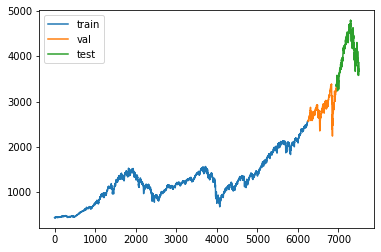

In [ ]:
# Load and visualize data
torch.manual_seed(args.seed)
dataloaders = load_data(df, **dataset_configs, **dataloader_configs)
train_loader, val_loader, test_loader = dataloaders

visualize_data(dataloaders, sample_idx=0)


### Part 1.2 SpaceTime Model

We'll now define a SpaceTime model. To do so, we specify individual config files that determine individual components such as the input layer (*i.e.,* the embedding layer), the encoder layers, the decoder layer, and the final output layer.

We explicitly write out the configs below, but they can also be found as `.yaml` files in `spacetime/configs/model/` (see the `spacetime/README.md` for more details).

In [ ]:
# We've got 4 main components to specify: 
# 1. The embedding / input projection (e.g., an MLP)
# 2. The encoder block ("open-loop" / convolutional SpaceTime SSMs go here)
# 3. The decoder block ("closed-loop" / recurrent SpaceTime SSMs go here)
# 4. The output projection (e.g., an MLP)

config_dir = 'spacetime/configs/'

In [ ]:
embedding_config = """
method: repeat
kwargs:
  input_dim: 1
  embedding_dim: null
  n_heads: 4
  n_kernels: 32
"""
embedding_config = OmegaConf.create(embedding_config)

In [ ]:
encoder_config = """
blocks:
- input_dim: 128
  pre_config: 'ssm/preprocess/residual'
  ssm_config: 'ssm/companion_preprocess'
  mlp_config: 'mlp/default'
  skip_connection: true
  skip_preprocess: false
"""
encoder_config = OmegaConf.create(encoder_config)

In [ ]:
decoder_config = """
blocks:
- input_dim: 128
  pre_config: 'ssm/preprocess/none'
  ssm_config: 'ssm/closed_loop/companion'
  mlp_config: 'mlp/identity'
  skip_connection: false
  skip_preprocess: false
"""
decoder_config = OmegaConf.create(decoder_config)

In [ ]:
output_config = """
input_dim: 128
output_dim: 1
method: mlp
kwargs:
  input_dim: 128
  output_dim: 1
  activation: gelu
  dropout: 0.2
  layernorm: false
  n_layers: 1
  n_activations: 1
  pre_activation: true
  input_shape: bld
  skip_connection: false
  average_pool: null
"""
output_config = OmegaConf.create(output_config)

#### Use configs to make a SpaceTime neural net

In [ ]:
from model.network import SpaceTime
from setup import seed_everything

In [ ]:
# Initialize SpaceTime encoder and decoder preprocessing, SSM, and MLP components
# - These are referenced as paths in the above encoder and decoder configs
def init_encoder_decoder_config(config, config_dir):
    for ix, _config in enumerate(config['blocks']):
        # Load preprocess kernel configs
        c_path = join(config_dir, f"{_config['pre_config']}.yaml")
        _config['pre_config'] = OmegaConf.load(c_path)
        # Load SSM kernel configs
        c_path = join(config_dir, f"{_config['ssm_config']}.yaml")
        _config['ssm_config'] = OmegaConf.load(c_path)
        # Load MLP configs
        c_path = join(config_dir, f"{_config['mlp_config']}.yaml")
        _config['mlp_config'] = OmegaConf.load(c_path)
    return config

In [ ]:
encoder_config = init_encoder_decoder_config(encoder_config, join(config_dir, 'model'))
decoder_config = init_encoder_decoder_config(decoder_config, join(config_dir, 'model'))

In [ ]:
# Initialize SpaceTime model
model_configs = {
    'embedding_config': embedding_config,
    'encoder_config': encoder_config,
    'decoder_config': decoder_config,
    'output_config': output_config,
    'lag': dataset_configs.lag,
    'horizon': dataset_configs.horizon
}
seed_everything(args.seed)

model = SpaceTime(**model_configs)

##### View architecture
We can either display the SpaceTime model as a PyTorch ``nn.Module`` object, or view the `OmegaConf` config behind it. 

In [ ]:
from utils.config import print_config  # View OmegaConf configs

In [ ]:
model  # PyTorch nn.Module view

SpaceTime(
  (embedding): RepeatEmbedding()
  (encoder): Encoder(
    (blocks): Sequential(
      (0): Block(
        (pre): ResidualSSM()
        (ssm): CompanionSSM()
        (mlp): MLP(
          (layernorm): Identity()
          (layers): Sequential(
            (0): GELU(approximate='none')
            (1): Dropout(p=0.2, inplace=False)
            (2): Linear(in_features=128, out_features=128, bias=True)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (blocks): ClosedLoopBlock(
      (pre): Identity()
      (ssm): ClosedLoopCompanionSSM()
      (mlp): Identity()
    )
  )
  (output): MLP(
    (layernorm): Identity()
    (layers): Sequential(
      (0): GELU(approximate='none')
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
print_config(model_configs)  # OmegaConf config view 
# (This might render as black text, not that useful here rip)

CONFIG
├── embedding_config
│   └── method: repeat                                                                                             
│       kwargs:                                                                                                    
│         input_dim: 1                                                                                             
│         embedding_dim: null                                                                                      
│         n_heads: 4                                                                                               
│         n_kernels: 32                                                                                            
│                                                                                                                  
├── encoder_config
│   └── blocks:                                                                                                    
│       - input_dim: 128                                                                                           
│         pre_config:                                                                                              
│           method: residual                                                                                       
│           kwargs:                                                                                                
│             max_diff_order: 4                                                                                    
│             min_avg_window: 4                                                                                    
│             max_avg_window: 64                                                                                   
│             model_dim: 128                                                                                       
│             n_kernels: 8                                                                                         
│             kernel_dim: 2                                                                                        
│             kernel_repeat: 16                                                                                    
│             n_heads: 1                                                                                           
│             head_dim: 1                                                                                          
│             kernel_weights: null                                                                                 
│             kernel_init: null                                                                                    
│             kernel_train: false                                                                                  
│             skip_connection: false                                                                               
│         ssm_config:                                                                                              
│           method: companion                                                                                      
│           kwargs:                                                                                                
│             model_dim: 128                                                                                       
│             n_kernels: 16                                                                                        
│             kernel_dim: 64                                                                                       
│             kernel_repeat: 1                                                                                     
│             n_heads: 8                                                                                           
│             head_dim: 1                                                                                          
│        

### Part 1.3 SpaceTime Model Training

We'll now specify the training configs and train our model

In [ ]:
from loss import get_loss
from data_transforms import get_data_transforms
from optimizer import get_optimizer, get_scheduler
from setup.configs.optimizer import get_optimizer_config, get_scheduler_config

from train import train_model, evaluate_model, plot_forecasts

#### Specify training args

In [ ]:
# Hacky training args, see the README or /spacetime/setup/args.py for details
arg_config = f"""
lag: {dataset_configs.lag}
horizon: {dataset_configs.horizon}
features: S
lr: 1e-3
weight_decay: 1e-4
dropout: 0.25
criterion_weights:
- 10
- 1
- 10
optimizer: adamw
scheduler: timm_cosine
max_epochs: 500
early_stopping_epochs: 20
data_transform: mean
loss: informer_rmse
val_metric: informer_rmse
seed: 42
dataset: sp500
variant: null
model: SpaceTime
"""
class Args():
    def __init__(self, args):
        for k, v in args.items():
            setattr(self, k, v)
            
args = Args(OmegaConf.create(arg_config))
# GPU
args.device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')

# These others are not super important
args.checkpoint_dir = './checkpoints'
args.log_dir = './log_dir'
args.variant = None
args.no_wandb = True
args.dataset_type = 'informer'  # for standard forecasting
args.log_epoch = 1000

In [ ]:
args.criterion_weights

[10, 1, 10]

#### Initialize optimizer, scheduler, criterions, data transforms

In [ ]:
seed_everything(args.seed)
model = SpaceTime(**model_configs)  # Reset model from here

model.set_lag(args.lag)
model.set_horizon(args.horizon)
    
# Initialize optimizer and scheduler
optimizer = get_optimizer(model, get_optimizer_config(args, config_dir))
scheduler = get_scheduler(model, optimizer, get_scheduler_config(args, config_dir))
    
# Loss objectives
criterions = {name: get_loss(name) for name in ['rmse', 'mse', 'mae']}
eval_criterions = criterions
for name in ['rmse', 'mse', 'mae']:
    eval_criterions[f'informer_{name}'] = get_loss(f'informer_{name}')
    
# Data transforms, e.g., normalization
input_transform, output_transform = get_data_transforms(args.data_transform, args.lag)

#### Train model

In [ ]:
from setup import initialize_experiment

In [ ]:
initialize_experiment(args, experiment_name_id='',
                      best_train_metric=1e10, 
                      best_val_metric=1e10)

-> Created model checkpoint saving directory at ./checkpoints/sp500!
-> Created logging directory at ./log_dir/spacetime-d=sp500-f=S-horizon=20!


In [ ]:
# Actually train model
splits = ['train', 'val', 'test']
dataloaders_by_split = {split: dataloaders[ix] 
                        for ix, split in enumerate(splits)}

model = train_model(model, optimizer, scheduler, dataloaders_by_split, 
                    criterions, max_epochs=args.max_epochs, config=args, 
                    input_transform=input_transform,
                    output_transform=output_transform,
                    val_metric=args.val_metric, wandb=None, 
                    return_best=True, early_stopping_epochs=args.early_stopping_epochs) 

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping at epoch 32...
-> Saved best val model checkpoint at epoch 12!
   - Saved to: ./checkpoints/sp500/bval-m=SpaceTime-la=84-ho=20-fe=S-dt=mean-cw=1+1+1-lo=ir-dr=0.25-lr=0.001-op=adamw-sc=tc-wd=0.0001-vm=ir-me=500-ese=20-se=42.pth
-> Saved best train model checkpoint at epoch 32!
   - Saved to: ./checkpoints/sp500/btrn-m=SpaceTime-la=84-ho=20-fe=S-dt=mean-cw=1+1+1-lo=ir-dr=0.25-lr=0.001-op=adamw-sc=tc-wd=0.0001-vm=ir-me=500-ese=20-se=42.pth
Returning best val model from epoch 12


### Evaluate model

In [ ]:
from dataloaders import get_evaluation_loaders
from train.evaluate import plot_forecasts

-----------------------------------------
Best validation model: eval_train metrics
-----------------------------------------
- total: 125080.0
- rmse: 1.6111050011366748
- mse: 1574.1868213132657
- mae: 27.767913052248122
- informer_rmse: 34.10065392450411
- informer_mse: 1577.7542958405554
- informer_mae: 27.7962796128526
----------------------------------
Best validation model: val metrics
----------------------------------
- total: 13880.0
- rmse: 5.1409068170816825
- mse: 21101.94696956052
- mae: 89.34690708303314
- informer_rmse: 110.30834605477072
- informer_mse: 21014.13413030451
- informer_mae: 89.41307570717551
-----------------------------------
Best validation model: test metrics
-----------------------------------
- total: 11200.0
- rmse: 7.126008747645787
- mse: 27546.71953125
- mae: 125.24329363141742
- informer_rmse: 150.36230426364475
- informer_mse: 27534.77454969618
- informer_mae: 125.78134388393826


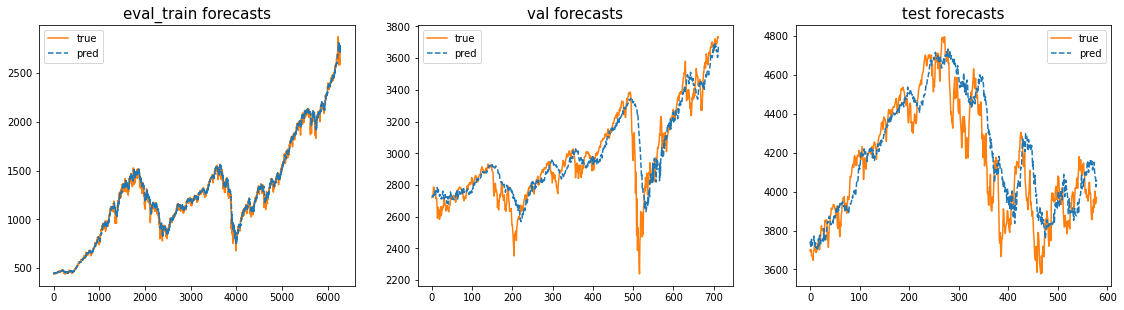

In [ ]:
eval_splits = ['eval_train', 'val', 'test']
eval_loaders = get_evaluation_loaders(dataloaders, batch_size=dataloader_configs.batch_size)
eval_loaders_by_split = {split: eval_loaders[ix] for ix, split in
                         enumerate(eval_splits)}
model, log_metrics, total_y = evaluate_model(model, dataloaders=eval_loaders_by_split, 
                                             optimizer=optimizer, scheduler=scheduler, 
                                             criterions=eval_criterions, config=args,
                                             epoch=args.best_val_metric_epoch, 
                                             input_transform=input_transform, 
                                             output_transform=output_transform,
                                             val_metric=args.val_metric, wandb=None,
                                             train=False)
n_plots = len(splits) # train, val, test
fig, axes = plt.subplots(1, n_plots, figsize=(6.4 * n_plots, 4.8))

plot_forecasts(total_y, splits=eval_splits, axes=axes)

-----------------------------------------
Best validation model: eval_train metrics
-----------------------------------------
- total: 125080.0
- rmse: 1.6111050011366748
- mse: 1574.1868213132657
- mae: 27.767913052248122
- informer_rmse: 34.10065392450411
- informer_mse: 1577.7542958405554
- informer_mae: 27.7962796128526
----------------------------------
Best validation model: val metrics
----------------------------------
- total: 13880.0
- rmse: 5.1409068170816825
- mse: 21101.94696956052
- mae: 89.34690708303314
- informer_rmse: 110.30834605477072
- informer_mse: 21014.13413030451
- informer_mae: 89.41307570717551
-----------------------------------
Best validation model: test metrics
-----------------------------------
- total: 11200.0
- rmse: 7.126008747645787
- mse: 27546.71953125
- mae: 125.24329363141742
- informer_rmse: 150.36230426364475
- informer_mse: 27534.77454969618
- informer_mae: 125.78134388393826


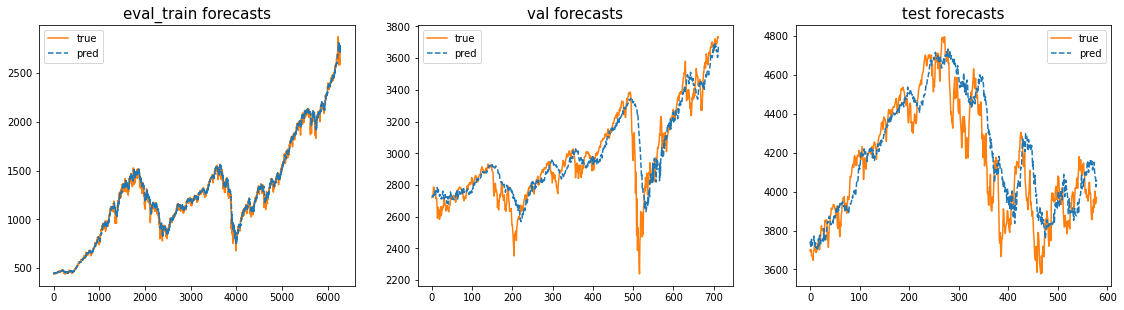

In [ ]:
eval_splits = ['eval_train', 'val', 'test']
eval_loaders = get_evaluation_loaders(dataloaders, batch_size=dataloader_configs.batch_size)
eval_loaders_by_split = {split: eval_loaders[ix] for ix, split in
                         enumerate(eval_splits)}
model, log_metrics, total_y = evaluate_model(model, dataloaders=eval_loaders_by_split, 
                                             optimizer=optimizer, scheduler=scheduler, 
                                             criterions=eval_criterions, config=args,
                                             epoch=args.best_val_metric_epoch, 
                                             input_transform=input_transform, 
                                             output_transform=output_transform,
                                             val_metric=args.val_metric, wandb=None,
                                             train=False)
n_plots = len(splits) # train, val, test
fig, axes = plt.subplots(1, n_plots, figsize=(6.4 * n_plots, 4.8))

plot_forecasts(total_y, splits=eval_splits, axes=axes)

## Part 2. Creating a trading bot

Great! If you're just interested in training SpaceTime for forecasting time-series, the above should suffice. 

However, we can also extend this demo further with our particular time-series data. 

Barring some sanity checks and further evaluations*, we'll now see if we can use the above to power a simple trading bot.

Again, *none of this is financial advice*.

<p></p>
<p></p>
<p></p>
---

*We'll look into some of this below. For example, is there actually predictable signal in our data, or is this the data just a random walk that SpaceTime is learning to follow (e.g., by predicting future time-steps as forward-lagged versions of the last input it sees)? 
* While we aim to mitigate this by predicting further out (e.g., horizon of 2 weeks vs 1 day), the above test set forecasts look oddly suspicious of this (which we're looking at for didactic purposes but in practice won't have *- another caveat to this demo!*)

---

### Part 2.1 Simple trading strategy

We'll follow the age-old adage of buying low and selling high. This might be easier said than done, but we'll attempt this with a simple forecasting strategy.  

We'll use our SpaceTime model to predict the stock price for some horizon into the future, given the available historical lag terms. 

#### Level 1: Long only trading
We'll act on these forecasts with a simple one-sided buying strat:  
* At any given time, if the forecasted price is higher than the current price (the last lag term in our input), **and** we have enough money to buy a single share at the current price, we'll buy (at the current price). 

* We'll then greedily ***hodl***, waiting until the current price ever reaches our predicted price. Once this happens, we'll sell our share bought at that predicted price.  
  * If we want to be slightly more advanced / cautious, we can define a margin where the current price doesn't need to exactly cross the predicted price. Instead, as long as `current_price - margin >= predicted_price`, we'll sell. 
  * We could also explore other variations of this; e.g., closing out the position after the horizon number of days passes, regardless of if the current price crosses our predicted prices 


#### Level 2: Long + short trading
We'll also extend the above with a bot that can short assets too. In that case, if the forecasted price is lower than the current price


---

### Part 2.2 Trading bot 
  
We'll implement the above with the following trading bot class. 

This isn't optimized for anything. So go wild extending the boilerplate and trading strats if you want.

In [ ]:
class TradingBot():
    def __init__(self, 
                 initial_budget: int, 
                 margin: float=0,
                 share_count: int=1,
                 model: any=None,
                 input_transform: any=None,
                 output_transform: any=None,
                 device: str='cuda:0'):
        """
        Args:
        - initial_budget: Budget we can trade with
        - margin: Dollars below (above) the predicted price 
                  that we'll sell (buy) at
        - share_count: Number of shares we'll trade if we want to and *can* trade
        - model: Forecasting model
        """
        super().__init__()
        self.budget = [initial_budget]  # Keep track of budget over time
        self.margin = margin
        self.share_count = share_count
        
        # Logging
        self.book = self.init_book()    # List of assets held
        self.close_position_delta = []  # List of relative gains or losses after closing positions
        self.log = []                   # List of all trades
        
        # Forecasting model
        self.model = model
        try: self.model.set_eval()  # Model might not be SpaceTime model
        except: pass
        transforms = self.init_transforms(input_transform,
                                          output_transform)
        self.input_transform, self.output_transform = transforms
        self.device = torch.device(device)
        
    def init_book(self):
        """
        Keeps track of the shares we bought and their prices
        - We're not doing anything fancy here with sorted data structures,
          someone else can implement that
        """
        book = {'long': np.array([]),
                'short': np.array([])}
        return book
    
    def init_transforms(self, input_transform: any, 
                        output_transform: any):
        if input_transform is None:
            input_transform = lambda x: x
        if output_transform is None:
            output_transform = lambda x: x
        return input_transform, output_transform
        
    def forecast(self, 
                 x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform model inference on lag terms. 
        - See spacetime/train/step/informer.py for more details.
        
        Inputs:
        - x: lag terms of shape (1, lag, 1) (batch, len, dim)
        
        Returns:
        - Tuple of (current price, forecasted price)
        """
        with torch.no_grad():
            try:
                self.model.to(self.device)
            except:
                pass
            u = self.input_transform(x)
            u = u.to(args.device)

            y, _ = self.model(u)
            y = self.output_transform(y[0]).cpu()
            
            y_curr = x[0, -1:, 0].item()
            y_pred = y[0, -1:, 0].item()
            return y_curr, y_pred
        
    def update_book(self):
        # See child classes for implementation
        raise NotImplementedError
        
    def trade(self):
        # See child classes for implementation
        raise NotImplementedError


In [ ]:
class LongBot(TradingBot):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def trade(self, lag_prices: torch.tensor, time: int):
        """
        The long strat.
        """
        # Forecast future price
        curr_price, pred_price = self.forecast(lag_prices)
        # Sell any bought shares where current price >= bought price
        revenue, returns = self.update_long_book(curr_price, time)
        self.budget.append(self.budget[-1] + revenue)
        self.close_position_delta.append(returns)

        # Buy any shares where predicted price > current price
        cost = self.buy(curr_price, pred_price, time)
        self.budget.append(self.budget[-1] - cost)
        
    def buy(self, curr_price: float, pred_price: float, time: int) -> float:
        buy_price = curr_price * self.share_count
        if (pred_price > curr_price and buy_price <= self.budget[-1]):
            # No optimization here
            self.book['long'] = np.insert(self.book['long'],
                                          0, buy_price)
            self.log.append({'trade': 'buy',
                             'price': buy_price,
                             'time': time})
            return buy_price
        return 0.
    
    def update_long_book(self, curr_price: float, time: int) -> float:
        """
        Returns updated buy book, along with price any assets were sold at
        """
        sell_indices = np.where(
            curr_price - self.margin >= self.book['long'])[0]
        sell_price = len(sell_indices) * curr_price
        
        # Compute returns from selling at current price - margin
        if len(sell_indices) > 0:
            returns = (curr_price - self.margin - self.book['long'][sell_indices]).sum()
        else:
            returns = 0

        self.book['long'] = np.delete(self.book['long'], sell_indices)
        if len(sell_indices) > 0:
            self.log.append({'trade': 'sell',
                             'price': sell_price,
                             'returns': returns,
                             'time': time})
        return sell_price, returns
        

In [ ]:
class LongShortBot(LongBot):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def trade(self, lag_prices: torch.tensor, time: int):
        """
        Bot can now long or short assets. Same workflow as before:
        1. Forecast price
        2. Greedily close-out any past positions
        3. Enter new positions based on predictions and current price
        """
        # Forecast future price
        curr_price, pred_price = self.forecast(lag_prices)

        # Sell any long shares where current price >= bought price
        revenue, long_returns = self.update_long_book(curr_price, time)
        # Buy back any short shares where current price <= sold price
        cost, short_returns = self.update_short_book(curr_price, time)
        self.budget.append(self.budget[-1] + revenue - cost)
        self.close_position_delta.append(long_returns + short_returns)

        # Buy any long shares where predicted price > current price
        cost = self.long(curr_price, pred_price, time)
        # Short any shares where predicted price < current price
        revenue = self.short(curr_price, pred_price, time)
        self.budget.append(self.budget[-1] + revenue - cost)
        
    def long(self, curr_price: float, pred_price: float, time: int) -> float:
        return super().buy(curr_price, pred_price, time)

    def short(self, curr_price: float, pred_price: float, time: int) -> float:
        sell_price = curr_price * self.share_count
        # We could be conservative here and only short if the price we borrow at 
        # is under our budget, but nah
        if pred_price < curr_price:  #  and sell_price <= self.budget[-1]:  
            # No optimization here
            self.book['short'] = np.insert(self.book['short'], 0, sell_price)
            self.log.append({'trade': 'short',
                             'price': sell_price,
                             'time': time})
            return sell_price
        return 0.

    def update_long_book(self, curr_price: float, time: int) -> float:
        return super().update_long_book(curr_price, time)
    
    def update_short_book(self, curr_price: float, time: int) -> float:
        buy_indices = np.where(
            curr_price + self.margin <= self.book['short'])[0]
        buy_back_price = len(buy_indices) * curr_price

        # Compute returns from buying at current price + margin
        if len(buy_indices) > 0:
            returns = (self.book['short'][buy_indices] - curr_price - self.margin).sum()
        else:
            returns = 0.
        
        self.book['short'] = np.delete(self.book['short'], buy_indices)
        if len(buy_indices) > 0:
            self.log.append({'trade': 'buy_back',
                             'price': buy_back_price,
                             'returns': returns,
                             'time': time})
        return buy_back_price, returns
        

### Part 2.3 Trading bot evaluation

#### Single-batch dataloading
Because we want a bot that can trade as data comes in, we'll set up a single-batch dataloader for our val and test sets (as opposed to the minibatch setup we did before, which would include future values)

In [ ]:
val_loader_sb = DataLoader(val_loader.dataset, shuffle=False, 
                           batch_size=1, num_workers=10)
test_loader_sb = DataLoader(test_loader.dataset, shuffle=False, 
                            batch_size=1, num_workers=10)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Trading and return functions

In [ ]:
def run_trading_session(bot, dataloader):
    # Run trading
    for ix, data in enumerate(dataloader):
        x, y, *z = data
        x = x[:, :args.lag, :]
        bot.trade(x, ix)
        
    # Fill out any remaining trades
    for ix, _y in enumerate(y[0, :, 0]):
        time = ix + bot.log[-1]['time'] if len(bot.log) > 0 else ix
        revenue, long_returns = bot.update_long_book(_y.item(), time)
        budget = bot.budget[-1]
        bot.budget.append(budget + revenue)
        bot.close_position_delta.append(long_returns)
        try:  # Hacks, only applies to bots that can short assets
            cost, short_returns = bot.update_short_book(_y.item(), time)
            budget = bot.budget[-1]
            bot.budget.append(budget - cost)
            bot.close_position_delta.append(short_returns)
        except:
            pass

    # Sell any long positions
    for price in bot.book['long']:   # The price initially bought at
        budget = bot.budget[-1]
        bot.budget.append(budget + _y )  # Sell at current price
        bot.close_position_delta.append(_y - price)  # Positive if current > bought_price
        bot.log.append({'trade': 'sell',
                        'price': _y,
                        'returns': _y - price,
                        'time': time})

    # Buy back any short positions
    for price in bot.book['short']:  # The price initially sold at
        budget = bot.budget[-1]  
        bot.budget.append(budget - _y)  # Buy back at current price
        bot.close_position_delta.append(price - _y)  # Positive if current < sold at
        bot.log.append({'trade': 'buy_back',
                        'price': _y,
                        'returns': price - _y,
                        'time': time})
        
    return bot
    

In [ ]:
def compute_positive_returns(bot, initial_budget):
    pos_returns = [0]
    for b in bot.budget:
        if b > initial_budget:
            pos_returns.append(b - initial_budget)
        else:
            pos_returns.append(pos_returns[-1])
    return pos_returns

#### Set baselines and alternatives

To get a better sense of how we actually do, we'll compare against three alternatives for trading.
1. **Last lag forecasts**: We'll adopt the same forecast-driven approach as above. But now, we'll just predict future prices as the last available lag terms (i.e., the most recent prices, reflecting an optimal approach if the data is truly a random walk). More on this below*
  * Note that this bot will never actually trade with the above strategy, because we're predicting that the price will remain the same.
  * This can still give us a sense of if our trained SpaceTime model is actually learning any useful signal (do we do better than not doing anything at all). 

2. **Trending lag forecasts**: We'll do the same as above, but to actually make some trades, we'll look back the same number of terms we're trying to predict out (e.g., the horizon), compute a mean trend, and apply this to the last lag term to predict our horizon.

3. **Buying and holding / Hodling**: We'll just go long on the asset 🚀🌕.

<p></p>
---

##### *Last lag forecasting
One (hidden) failure mode might be that the model might just be using the last lag terms as predictions for the horizon terms (e.g., as noted in this [demo training an LSTM to predict stock price data](https://towardsdatascience.com/how-not-to-predict-stock-prices-with-lstms-a51f564ccbca)). In other words, we're just predicting prices close to the last prices seen. 
* Now if the data truly is unpredictable as a random walk, then we'd actually expect this kind of behavior. However, this also means our model isn't able to learn anything useful dependencies between historical and future data to predict future prices.  


In [ ]:
class LastLagBot(LongShortBot):
    """
    Trading bot that uses the current price as forecasts for future prices,
    and trades based on these predictions.
    - In reality, a last lag bot will never trade
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forecast(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Only method we override. Instead of using a trained model, we'll
        just predict the current price (last lag input) to be the future price
        - But then the bot will never trade
        """
        y_curr = x[0, -1:, 0].item()
        y_pred = y_curr
        return y_curr, y_pred


In [ ]:
class TrendLagBot(LongShortBot):
    """
    Trading bot that uses the current price as forecasts for future prices,
    and trades based on these predictions.
    - In reality, a last lag bot will never trade
    """
    def __init__(self, trend_window, **kwargs):
        assert trend_window >= 0
        self.trend_window = trend_window
        super().__init__(**kwargs)

    def forecast(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Only method we override. Instead of using a trained model, we'll
        just predict the current price (last lag input) to be the future price
        - But then the bot will never trade
        """
        y_curr = x[0, -1:, 0].item()
        trend_window = min(self.trend_window, x.shape[1])  # Assume x is shape B x L x D
        y_pred = y_curr + max(y_curr - x[0, -trend_window, 0].item(), 0) 
        return y_curr, y_pred


In [ ]:
class HODLBot(LongBot):
    """
    Trading bot that just buys and holds. To reflect this position over time, 
    we always predict that price will go up.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forecast(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Only method we override. Instead of using a trained model, we'll
        just predict the current price (last lag input) to be the future price
        - But then the bot will never trade
        """
        y_curr = x[0, -1:, 0].item()
        y_pred = y_curr + 1  # Reflect positivity + belief that price will go up
        return y_curr, y_pred


### Part 2.4 Trading time

We'll compare the performance of a long-only SpaceTime trading bot, and a SpaceTime bot that can take long and short positions, with the above baselines.

In [ ]:
initial_budget = 10000        # Standard brokerage
margin = 0                    # Keep things simple
eval_loader = test_loader_sb  # Evaluate on test dates

# Initialize trading bots
spacetime_long_bot = LongBot(initial_budget=initial_budget, 
                             margin=margin,
                             share_count=1,
                             model=model,
                             input_transform=input_transform,
                             output_transform=output_transform,
                             device=args.device)

spacetime_longshort_bot = LongShortBot(initial_budget=initial_budget, 
                                       margin=margin,
                                       share_count=1,
                                       model=model,
                                       input_transform=input_transform,
                                       output_transform=output_transform,
                                       device=args.device)

last_lag_bot = LastLagBot(initial_budget=initial_budget, 
                          margin=margin,
                          share_count=1,
                          model=None,
                          input_transform=None,
                          output_transform=None,
                          device='cpu')

trend_lag_bot = TrendLagBot(initial_budget=initial_budget, 
                            margin=margin,
                            share_count=1,
                            trend_window=args.horizon,
                            model=None,
                            input_transform=None,
                            output_transform=None,
                            device='cpu')

hodl_bot = HODLBot(initial_budget=initial_budget, 
                   margin=margin,
                   share_count=1,
                   model=None,
                   input_transform=None,
                   output_transform=None,
                   device='cpu')

# Run trading session
spacetime_long_bot = run_trading_session(spacetime_long_bot, eval_loader)
spacetime_longshort_bot = run_trading_session(spacetime_longshort_bot, eval_loader)
last_lag_bot = run_trading_session(last_lag_bot, eval_loader)
trend_lag_bot = run_trading_session(trend_lag_bot, eval_loader)
hodl_bot = run_trading_session(hodl_bot, eval_loader)

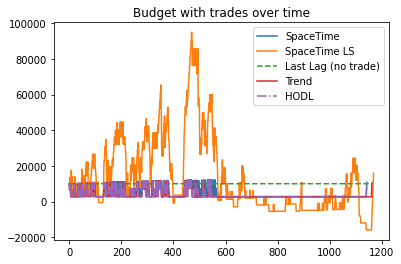

In [ ]:
## Budget over time
plt.plot(spacetime_long_bot.budget, label='SpaceTime')
plt.plot(spacetime_longshort_bot.budget, label='SpaceTime LS')
plt.plot(last_lag_bot.budget, label='Last Lag (no trade)', linestyle='--')
plt.plot(trend_lag_bot.budget, label='Trend')
plt.plot(hodl_bot.budget, label='HODL', linestyle='-.')
plt.title('Budget with trades over time')
plt.legend()
plt.show()

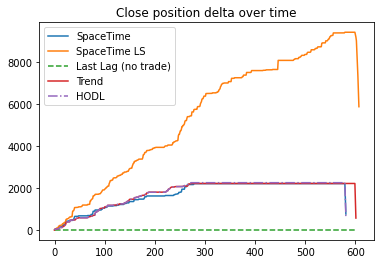

In [ ]:
# Plot cumulative close position deltas over time
plt.plot(np.cumsum(spacetime_long_bot.close_position_delta), label='SpaceTime')
plt.plot(np.cumsum(spacetime_longshort_bot.close_position_delta), label='SpaceTime LS')
plt.plot(np.cumsum(last_lag_bot.close_position_delta), label='Last Lag (no trade)', linestyle='--')
plt.plot(np.cumsum(trend_lag_bot.close_position_delta), label='Trend')
plt.plot(np.cumsum(hodl_bot.close_position_delta), label='HODL', linestyle='-.')
plt.title('Close position delta over time')
plt.legend()
plt.show()

<ipython-input-64-202da85433c2>:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plot)


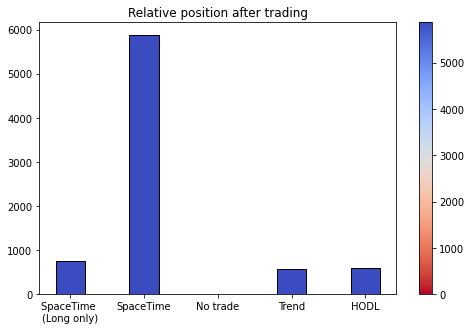

In [ ]:
bots = ['SpaceTime \n(Long only)', 'SpaceTime', 'No trade', 'Trend', 'HODL']
deltas = [np.cumsum(spacetime_long_bot.close_position_delta)[-1],
          np.cumsum(spacetime_longshort_bot.close_position_delta)[-1],
          np.cumsum(last_lag_bot.close_position_delta)[-1],
          np.cumsum(trend_lag_bot.close_position_delta)[-1],
          np.cumsum(hodl_bot.close_position_delta)[-1]]

fig = plt.figure(figsize = (8, 5))
plot = plt.scatter(deltas, deltas, c = deltas, cmap = 'coolwarm_r')
plt.clf()
plt.colorbar(plot)
plt.bar(bots, deltas, width = 0.4, color=plt.cm.coolwarm_r(deltas),
        edgecolor='black')
plt.axhline(y=0, linewidth=1, color='k')
plt.title('Relative position after trading')
plt.show()

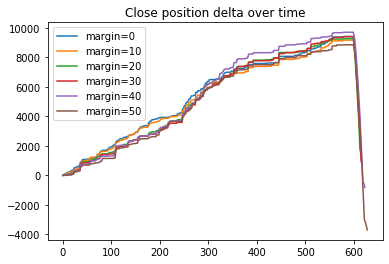

<ipython-input-65-184b4774dbe3>:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plot)


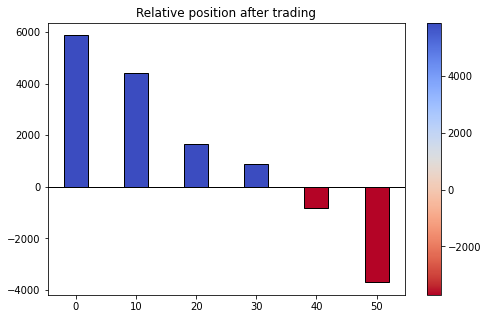

In [ ]:
## More fun, play around with trading margin
initial_budget = 10000        # Standard brokerage
eval_loader = test_loader_sb  # Evaluate on test dates

margins = [0, 10, 20, 30, 40, 50]
bots = []
for margin in margins:
    spacetime_longshort_bot = LongShortBot(initial_budget=initial_budget, 
                                           margin=margin,
                                           share_count=1,
                                           model=model,
                                           input_transform=input_transform,
                                           output_transform=output_transform,
                                           device=args.device)
    spacetime_longshort_bot = run_trading_session(spacetime_longshort_bot, eval_loader)
    bots.append(spacetime_longshort_bot)

    plt.plot(np.cumsum(spacetime_longshort_bot.close_position_delta), label=f'margin={margin}')
plt.title('Close position delta over time')
plt.legend()
plt.show()

deltas = [np.cumsum(bot.close_position_delta)[-1] for bot in bots]

fig = plt.figure(figsize = (8, 5))
plot = plt.scatter(deltas, deltas, c = deltas, cmap = 'coolwarm_r')
plt.clf()
plt.colorbar(plot)
plt.bar([str(m) for m in margins], deltas, width = 0.4, color=plt.cm.coolwarm_r(deltas),
        edgecolor='black')
plt.axhline(y=0, linewidth=1, color='k')
plt.title('Relative position after trading')
plt.show()

